## Amazon Timestream With SageMaker
This is a notebook where we try to estimate the values of the sensors in out Timestream database with the N-BEATS-algorithm implemented by [darts](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.nbeats.html?highlight=nbeats#darts.models.forecasting.nbeats.NBEATSModel) python package

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
import timestreamquery as timestream
from IPython import display
import pandas as pd
import boto3
import botocore
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts.models import NBEATSModel, TFTModel
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import holidays_timeseries
# import sagemaker
import sys
import seaborn as sns
import numpy as np
import holidays
import datetime as dt

In [2]:
#################################################
##### Timestream Configurations.  ###############
#################################################
ENDPOINT = "eu-west-1" # <--- specify the region service endpoint
PROFILE = "mose-timestream" # <--- specify the AWS credentials profile
DB_NAME = "SensorData" # <--- specify the database created in Amazon Timestream
TABLE_NAME = "particleTest" # <--- specify the table created in Amazon Timestream
TABLE_NAME_PAST = "yrPast" # <--- specify the table created in Amazon Timestream
TABLE_NAME_PREDICTION = "yrPrediction" # <--- specify the table created in Amazon Timestream


client = timestream.createQueryClient(ENDPOINT, profile=PROFILE)

#################################################
##### SageMaker Configurations. #################
#################################################

eu-west-1


## Logical view of data ##
```sql
DESCRIBE <db_name>.<table_name>
```

In [3]:
query_describe = """
DESCRIBE {}.{}
""".format(DB_NAME, TABLE_NAME)

describe_table = timestream.executeQueryAndReturnAsDataframe(client, query_describe, True)

display.display(describe_table)

QueryId: AEDQCANH3WRXWMNTUGRS6YRAV2LN2VO2H4BJAGVFZS3PELLGPYGFQOIXQFZFYRY
2022-10-25 14:27:20. QueryId: AEDQCANH3WRXWMNTUGRS6YRAV2LN2VO2H4BJAGVFZS3PELLGPYGFQOIXQFZFYRY Time: 1.64. First result: 1.64. Time to read results: 0.0.


,Column,Type,Timestream attribute type
0,tagId,varchar,DIMENSION
1,gateway_id,varchar,DIMENSION
2,measure_name,varchar,MEASURE_NAME
3,time,timestamp,TIMESTAMP
4,temperature,double,MULTI
5,humidity,double,MULTI
6,mc_2_5,bigint,MULTI
7,mc_10_0,bigint,MULTI
8,mc_4_0,bigint,MULTI
9,nc_10_0,bigint,MULTI


In [4]:
sensors = describe_table[describe_table["Timestream attribute type"] == "MULTI"]["Column"]
columns_to_extract = ", ".join([f"ROUND(AVG({sensor_name}), 2) as {sensor_name}_" for sensor_name in sensors])


In [5]:
query_get_all_data = f"""
SELECT BIN(time, 1h) as time_, {columns_to_extract}
FROM {DB_NAME}.{TABLE_NAME}
GROUP BY BIN(time, 1h)
ORDER BY BIN(time, 1h)
"""

df = timestream.executeQueryAndReturnAsDataframe(client, query_get_all_data, True)
display.display(df)

QueryId: AEDQCANH3WRUIP2VAL4XA3J27XT3MH6FF5S6F3SF7LBEQWLJYHU77GIGY3CTFJQ
2022-10-25 14:27:21. QueryId: AEDQCANH3WRUIP2VAL4XA3J27XT3MH6FF5S6F3SF7LBEQWLJYHU77GIGY3CTFJQ Time: 1.615. First result: 1.615. Time to read results: 0.0.


,time_,temperature_,humidity_,mc_2_5_,mc_10_0_,mc_4_0_,nc_10_0_,mc_1_0_,nc_0_5_,nc_2_5_,nc_1_0_,nc_4_0_,typical_particle_size_
0,2022-09-16 14:00:00.000000000,11.90,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-09-16 15:00:00.000000000,11.77,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-09-16 16:00:00.000000000,11.88,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-09-16 17:00:00.000000000,11.83,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-09-16 18:00:00.000000000,11.74,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,2022-10-25 10:00:00.000000000,8.62,99.0,7.67,8.83,8.58,52.58,6.58,43.67,52.42,51.58,52.58,630.58
933,2022-10-25 11:00:00.000000000,9.19,99.0,16.00,17.25,17.08,114.58,14.08,97.75,114.42,113.25,114.58,564.25
934,2022-10-25 12:00:00.000000000,9.84,99.0,6.75,8.08,7.67,44.25,5.67,36.17,44.08,43.25,44.25,650.75
935,2022-10-25 13:00:00.000000000,9.49,99.0,3.25,5.08,4.58,14.83,1.75,9.83,14.75,13.33,14.83,808.83


In [6]:
query_describe_past = """
DESCRIBE {}.{}
""".format(DB_NAME, TABLE_NAME_PAST)

describe_table_past = timestream.executeQueryAndReturnAsDataframe(client, query_describe_past, True)

yr_past_columns = describe_table_past[describe_table_past["Timestream attribute type"] == "MULTI"]["Column"]
columns_to_extract_past = ", ".join([f'ROUND(AVG("{column}"), 2) as "{column}_"' for column in yr_past_columns if column != "max(air_temperature PT1H)"])
query_get_all_data_past = f"""
SELECT BIN(time, 1h) as time_, {columns_to_extract_past}
FROM {DB_NAME}.{TABLE_NAME_PAST}
GROUP BY BIN(time, 1h)
ORDER BY BIN(time, 1h)
"""

df_past = timestream.executeQueryAndReturnAsDataframe(client, query_get_all_data_past, True)
display.display(df_past)

QueryId: AEDQCANH3WR6HO2PCWORMC4YGEJ4CVMTSJQLPULCC4IS5RIP2HPFPRSU5TC6Y5A
2022-10-25 14:27:21. QueryId: AEDQCANH3WR6HO2PCWORMC4YGEJ4CVMTSJQLPULCC4IS5RIP2HPFPRSU5TC6Y5A Time: 0.174. First result: 0.174. Time to read results: 0.0.
QueryId: AEDQCANH3WRZAME73POH4JW7PXHZHLA674A7N5PLQNNACSSRTOQYP4XAS5Z7K6Q
2022-10-25 14:27:22. QueryId: AEDQCANH3WRZAME73POH4JW7PXHZHLA674A7N5PLQNNACSSRTOQYP4XAS5Z7K6Q Time: 0.496. First result: 0.496. Time to read results: 0.0.


,time_,sum(precipitation_amount PT1H)_,max(wind_speed PT1H)_,wind_direction_sin_,wind_direction_cos_
0,2022-08-01 00:00:00.000000000,0.3,3.1,-0.85,-0.53
1,2022-08-01 01:00:00.000000000,0.1,2.6,-0.72,-0.69
2,2022-08-01 02:00:00.000000000,0.5,2.5,-0.72,-0.69
3,2022-08-01 03:00:00.000000000,0.3,2.6,-0.92,-0.39
4,2022-08-01 04:00:00.000000000,0.5,2.5,-0.69,-0.72
...,...,...,...,...,...
2049,2022-10-25 09:00:00.000000000,0.0,2.3,0.31,-0.95
2050,2022-10-25 10:00:00.000000000,0.0,2.4,0.09,-1.00
2051,2022-10-25 11:00:00.000000000,0.0,2.1,0.07,-1.00
2052,2022-10-25 12:00:00.000000000,0.0,2.1,-0.02,-1.00


In [7]:
query_describe_prediction = """
DESCRIBE {}.{}
""".format(DB_NAME, TABLE_NAME_PREDICTION)

describe_table_prediction = timestream.executeQueryAndReturnAsDataframe(client, query_describe_prediction, True)

yr_prediction_columns = describe_table_prediction[describe_table_prediction["Timestream attribute type"] == "MULTI"]["Column"]
columns_to_extract_prediction = ", ".join([f'ROUND(AVG("{column}"), 2) as "{column}_"' for column in yr_prediction_columns])
query_get_all_data_prediction = f"""
SELECT BIN(time, 1h) as time_, {columns_to_extract_prediction}
FROM {DB_NAME}.{TABLE_NAME_PREDICTION}
GROUP BY BIN(time, 1h)
ORDER BY BIN(time, 1h)
"""

df_prediction = timestream.executeQueryAndReturnAsDataframe(client, query_get_all_data_prediction, True)

QueryId: AEDQCANH3WRQJENA7YU7WUCNQIZ7HXCZU5NNAWZZ5OKWTFMDI3C2EYO6PNBZ4SA
2022-10-25 14:27:22. QueryId: AEDQCANH3WRQJENA7YU7WUCNQIZ7HXCZU5NNAWZZ5OKWTFMDI3C2EYO6PNBZ4SA Time: 0.258. First result: 0.258. Time to read results: 0.0.
QueryId: AEDQCANH3WRXUNWLX44GMF3T7Q44WSFVL6CG7GTI6TR4O547Y2D4NYOFW3XMQSI
2022-10-25 14:27:27. QueryId: AEDQCANH3WRXUNWLX44GMF3T7Q44WSFVL6CG7GTI6TR4O547Y2D4NYOFW3XMQSI Time: 4.529. First result: 2.486. Time to read results: 2.043.


In [8]:
def is_workday(idx):
    print(idx.year)
    date = dt.date(idx.year, idx.month, idx.day)
    return not (date in holidays.NO() or date.weekday() > 4)

In [9]:
def workday_series(datetime_index: pd.DatetimeIndex):
    """Checks if an datetimeIndex is a Norwegian workday 

    :param date: a datetimeIndex object to check 
    :return: TimeSeries of workdays
    """    
    holidays_series = holidays_timeseries(datetime_index, country_code="NO").pd_series() == 1.
    weekdays = datetime_index.to_series().dt.dayofweek <= 4
    df = pd.DataFrame({"weekday": weekdays, "holidays": holidays_series})
    df = df.apply(lambda row: row['weekday'] & ~row['holidays'], axis=1)
    return df

In [10]:
add_encoders = {
    'datetime_attribute': {'past': ['hour', ], 'future': ['hour']},
    'custom': {'past': [workday_series], 'future': [workday_series]},
    'transformer': Scaler()
}
scaler = Scaler()

In [11]:
import os
LOAD = False         # True = load previously saved model from disk?  False = (re)train the model
SAVE = "\_TFT_model_00.pth.tar"   # file name to save the model under

EPOCHS = 100
INLEN = 168         # input size, one week
BLOCKS = 64         
LWIDTH = 32
BATCH = 32          # batch size
LEARN = 1e-2        # learning rate
VALWAIT = 1         # epochs to wait before evaluating the loss on the test/validation set
N_FC = 24           # output size, one day

RAND = 42           # random seed
N_SAMPLES = 100     # number of times a prediction is sampled from a probabilistic model
N_JOBS = -1         # parallel processors to use;  -1 = all processors

# default quantiles for QuantileRegression
QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]

SPLIT = 0.9         # train/test %

FIGSIZE = (9, 6)


qL1, qL2 = 0.01, 0.10        # percentiles of predictions: lower bounds
qU1, qU2 = 1-qL1, 1-qL2,     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'

mpath = os.path.abspath(os.getcwd()) + SAVE

# Set up N-BEATS model and train the model

In [18]:
df.index = pd.to_datetime(df.time_)
df.index = df.index.tz_localize(None)
series = fill_missing_values(
    TimeSeries.from_dataframe(df, value_cols=[sensor_name + "_" for sensor_name in sensors], fill_missing_dates=True))

2022-10-11 12:43:45 darts.timeseries WARNING: Number of components is larger than 10 (12). Plotting only the first 10 components.


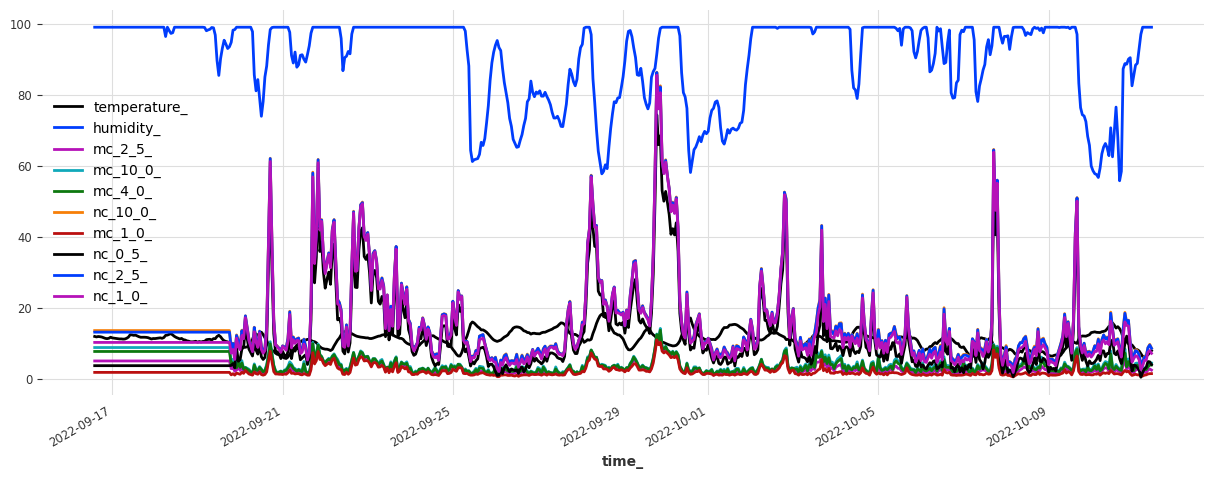

In [19]:
series.plot()

In [185]:
train, val = series[:-24], series[-24:]
model_nbeats = NBEATSModel(    input_chunk_length=INLEN,
                        output_chunk_length=N_FC, 
                        num_stacks=BLOCKS,
                        layer_widths=LWIDTH,
                        batch_size=BATCH,
                        n_epochs=10,
                        nr_epochs_val_period=VALWAIT, 
                        likelihood=QuantileRegression(QUANTILES), 
                        optimizer_kwargs={"lr": LEARN}, 
                        model_name="NBEATS_EnergyES",
                        log_tensorboard=True,
                        generic_architecture=True, 
                        random_state=RAND,
                        force_reset=True,
                        save_checkpoints=True,
                        add_encoders=add_encoders
                    )

In [186]:
series_train_scaled, series_past_scaled, series_prediction_scaled = scaler.fit_transform([series_train, series_past, series_prediction])

if LOAD:
    print("have loaded a previously saved model from disk:" + mpath)
    model_nbeats = NBEATSModel.load_model(mpath)                            # load previously model from disk 
else:
    model_nbeats.fit(  series=series_train_scaled, 
                past_covariates=series_past_scaled,
                # val_series=val,
                verbose=True)
    print("have saved the model after training:", mpath)
    model_nbeats.save(mpath)

c:\Users\haako\Anaconda3\envs\tdt4290\lib\site-packages\darts\timeseries.py:4079: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  if isinstance(time_idx, pd.Int64Index) and not isinstance(
2022-10-24 12:21:16 darts.utils.data.encoders WARNING: Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
2022-10-24 12:21:16 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-24 12:21:16 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-24 12:21:16 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
2022-10-24 12:21:16 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss      

Training: 0it [00:00, ?it/s]

have saved the model after training: c:\Users\haako\Documents\_NTNU\_2022Host\Kundestyrt\timeseries-prediction\_TFT_model_00.pth.tar


In [187]:
prediction_nbeats = model_nbeats.predict(n=24, num_samples=1000, series=series_train_scaled[-480:], past_covariates=series_past_scaled)

Predicting: 16it [00:00, ?it/s]

In [21]:
print(series.columns)
series_scaled["temperature_"].plot()
prediction_nbeats['temperature_'].plot(low_quantile=0.05, high_quantile=0.95)

Index(['temperature_', 'humidity_', 'mc_2_5_', 'mc_10_0_', 'mc_4_0_',
       'nc_10_0_', 'mc_1_0_', 'nc_0_5_', 'nc_2_5_', 'nc_1_0_', 'nc_4_0_',
       'typical_particle_size_'],
      dtype='object', name='component')


NameError: name 'series_scaled' is not defined

# Setting up TFTModel with predictions from yr

In [12]:
EPOCHS = 200
INLEN = 168
HIDDEN = 64
LSTMLAYERS = 1
ATTHEADS = 1
DROPOUT = 0.2
BATCH = 32

N_FC = 24           # default forecast horizon
RAND = 42           # set random state
N_SAMPLES = 100     # number of times a prediction is sampled from a probabilistic model
N_JOBS = -1          # parallel processors to use;  -1 = all processors

# default quantiles for QuantileRegression
QUANTILES = [0.01, 0.05, 0.1, 0.2, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95, 0.99]

TRAIN = "19571201"  # train/test split
MSEAS = 60          # max seasonality to check: months
ALPHA = 0.05        # significance level for seasonality test
FIGSIZE = (9, 6)

qL1, qL2, qL3 = 0.01, 0.05, 0.10        # percentiles of predictions: lower bounds
qU1, qU2, qU3 = 1-qL1, 1-qL2, 1-qL3     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'
label_q3 = f'{int(qU3 * 100)} / {int(qL3 * 100)} percentile band'
SAVE = "\_TFT_model_100.pth.tar"   # file name to save the model under
mpath = os.path.abspath(os.getcwd()) + SAVE
LOAD = False

In [13]:
scaler_temp = Scaler()
scaler_wind_speed = Scaler()
scaler_percipitation = Scaler()
scaler_series_general = Scaler()

In [14]:
df.index = pd.to_datetime(df.time_)
df.index = df.index.tz_localize(None)
series = fill_missing_values(
    TimeSeries.from_dataframe(df, value_cols=[sensor_name + "_" for sensor_name in sensors if sensor_name != "temperature"], fill_missing_dates=True))
series_temp = fill_missing_values(
    TimeSeries.from_dataframe(df, value_cols=["temperature_"], fill_missing_dates=True))


df_past.index = pd.to_datetime(df_past.time_)
df_past.index = df_past.index.tz_localize(None)
series_past_wind_speed = fill_missing_values(
    TimeSeries.from_dataframe(df_past, value_cols=["max(wind_speed PT1H)_"], fill_missing_dates=True))
series_past_wind_sin = fill_missing_values(
    TimeSeries.from_dataframe(df_past, value_cols=["wind_direction_sin_"], fill_missing_dates=True))
series_past_wind_cos = fill_missing_values(
    TimeSeries.from_dataframe(df_past, value_cols=["wind_direction_cos_"], fill_missing_dates=True))
series_past_percipitation = fill_missing_values(
    TimeSeries.from_dataframe(df_past, value_cols=["sum(precipitation_amount PT1H)_"], fill_missing_dates=True))

In [15]:
df_prediction.index = pd.to_datetime(df_prediction.time_)
df_prediction.index = df_prediction.index.tz_localize(None)
series_prediction_air_temp = fill_missing_values(
    TimeSeries.from_dataframe(df_prediction, value_cols=[
        '1h_air_temperature_', 
        ], fill_missing_dates=True)
)
series_prediction_wind_speed = fill_missing_values(
    TimeSeries.from_dataframe(df_prediction, value_cols=[
        '1h_wind_speed_', 
        ], fill_missing_dates=True)
)
series_prediction_percipitation = fill_missing_values(
    TimeSeries.from_dataframe(df_prediction, value_cols=[
        '1h_percipitation_', 
        ], fill_missing_dates=True)
)
series_prediction_wind_sin = fill_missing_values(
    TimeSeries.from_dataframe(df_prediction, value_cols=[
        '1h_wind_direction_sin_', 
        ], fill_missing_dates=True)
)
series_prediction_wind_cos = fill_missing_values(
    TimeSeries.from_dataframe(df_prediction, value_cols=[
        '1h_wind_direction_cos_', 
        ], fill_missing_dates=True)
)

In [16]:
model_tft = TFTModel(
    input_chunk_length=INLEN,
    output_chunk_length=N_FC,
    hidden_size=HIDDEN,
    lstm_layers=LSTMLAYERS,
    num_attention_heads=ATTHEADS,
    dropout=DROPOUT,
    batch_size=BATCH,
    n_epochs=EPOCHS,
    likelihood=QuantileRegression(quantiles=QUANTILES), 
    # loss_fn=MSELoss(),
    random_state=RAND, 
    force_reset=True,
    full_attention=True,
    # optimizer_kwargs={"lr": LEARN}, 
    model_name="TFT_environment",
    log_tensorboard=True,
    save_checkpoints=True,
    add_encoders=add_encoders
)

In [17]:
from darts.metrics import rmse
from darts import concatenate
series_train, series_test = series.split_before(0.8)
series_train_temp, series_test_temp = series_temp.split_before(0.8)
series_train_v, series_val = series_train.split_before(0.7)
series_train_temp_v, series_val_temp = series_train_temp.split_before(0.7)


series_train_temp_v_scaled = scaler_temp.fit_transform(series_train_temp_v)
series_val_temp_scaled = scaler_temp.transform(series_val_temp)
series_test_temp_scaled = scaler_temp.transform(series_test_temp)

series_train_v_scaled = scaler_series_general.fit_transform(series_train_v)
series_val_scaled = scaler_series_general.transform(series_val)
series_test_scaled = scaler_series_general.transform(series_test)

series_train_scaled_stacked = concatenate([series_train_v_scaled, series_train_temp_v_scaled], axis="component")
series_val_scaled_stacked = concatenate([series_val_scaled, series_val_temp_scaled], axis="component")
series_test_scaled_stacked = concatenate([series_test_scaled, series_test_temp_scaled], axis="component")


series_past_wind_speed_scaled = scaler_wind_speed.fit_transform(series_past_wind_speed)
series_past_percipitation_scaled = scaler_percipitation.fit_transform(series_past_percipitation)
series_past_wind_speed_scaled = scaler_wind_speed.fit_transform(series_past_wind_speed)


series_prediction_wind_speed_scaled = scaler_wind_speed.transform(series_prediction_wind_speed)
series_prediction_percipitation_scaled = scaler_percipitation.transform(series_prediction_percipitation)
series_prediction_wind_speed_scaled = scaler_wind_speed.transform(series_prediction_wind_speed)


past_covariates = concatenate([series_past_wind_speed_scaled, series_past_percipitation_scaled, series_past_wind_speed_scaled, series_past_wind_cos, series_past_wind_sin], axis="component")
future_covariates = concatenate(
    [series_prediction_wind_speed_scaled, series_prediction_percipitation_scaled, series_prediction_wind_speed_scaled, series_prediction_wind_cos, series_prediction_wind_sin],
    axis="component")




In [18]:
def eval_model(model, series=series, past_covariates=None, future_covariates=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series=series, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=0.8, 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=24)
    
    backtest.plot(label='backtest (n=24)')
    return backtest


In [ ]:
# series_train_v_scaled, series_val_scaled, series_past_scaled, series_prediction_scaled = scaler.fit_transform([series_train_v, series_val, series_past, series_prediction])
if LOAD:
    print("have loaded a previously saved model from disk:" + mpath)
    model_tft = TFTModel.load_model(mpath)                            # load previously model from disk 
else:
    model_tft.fit(
        series_train_scaled_stacked, 
        val_series=series_val_scaled_stacked,
        past_covariates=past_covariates,
        future_covariates=future_covariates, 
        val_past_covariates=past_covariates,
        val_future_covariates=future_covariates, 
        epochs=EPOCHS, 
        verbose=True)
    print("have saved the model after training:", mpath)
    model_tft.save(mpath)



2022-10-25 16:27:34 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-10-25 16:27:34 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-10-25 16:27:34 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-10-25 16:27:34 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-10-25 16:27:34 pytorch_lightning.callbacks.model_summary INFO: 
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn        

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\haako\Anaconda3\envs\tdt4290\lib\site-packages\pytorch_lightning\trainer\trainer.py:1892: PossibleUserWarning: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [18]:
model_tft.save(mpath)

  0%|          | 0/162 [00:00<?, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

2022-10-25 10:04:49 darts.timeseries WARNING: Number of components is larger than 10 (12). Plotting only the first 10 components.


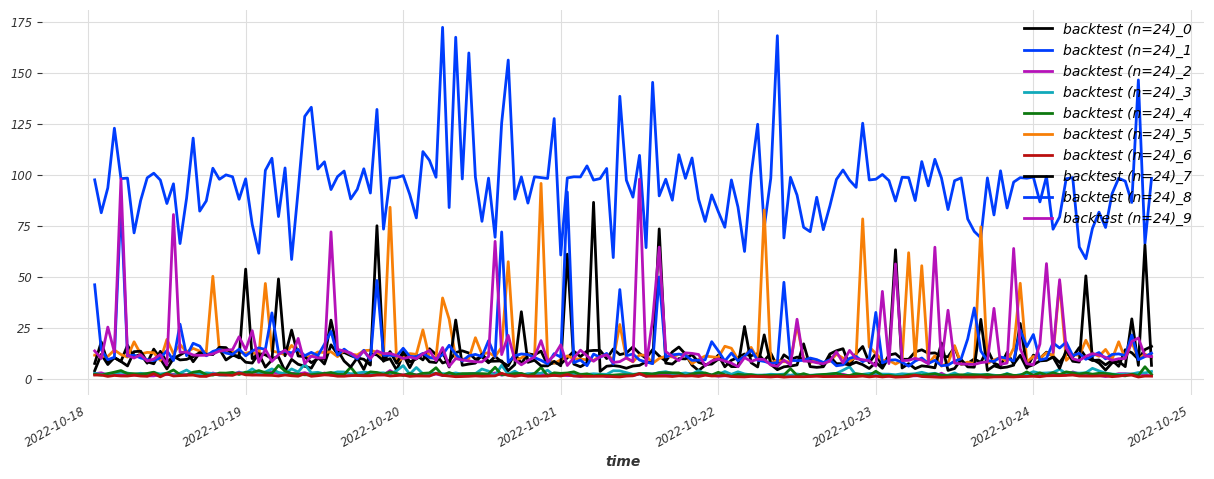

In [91]:
back_test = eval_model(
    model_tft, 
    series=concatenate([scaler_series_general.transform(series), scaler_temp.transform(series_temp)]), 
    past_covariates=past_covariates, 
    future_covariates=future_covariates
)

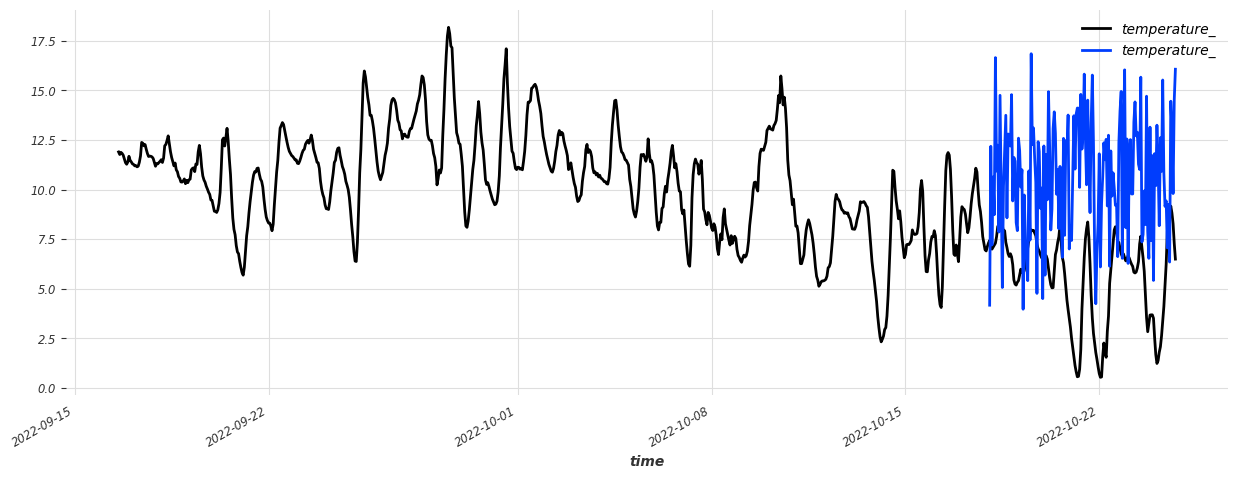

In [ ]:
series_temp['temperature_'].plot()
scaler_temp.inverse_transform(back_test['temperature_']).plot()

In [94]:
from darts.metrics import mape
def mape_error(name=None):
    if name is None:
        print(
            "Mean absolute percentage error for the all features: {:.2f}%.".format(
                mape(series, back_test)
            )
        )
    else:
        print("Mean absolute percentage error for {} features: {:.2f}%.".format(name, 
                mape(series[name], back_test[name]))
            )

In [95]:
mape_error("mc_1_0_")
mape_error("humidity_")
mape_error()

Mean absolute percentage error for mc_1_0_ features: 48.10%.
Mean absolute percentage error for humidity_ features: 14.10%.
Mean absolute percentage error for the all features: 74.61%.


In [19]:
prediction_tft = model_tft.predict(n=24, past_covariates=series_past_scaled, future_covariates=series_prediction_scaled, num_samples=1000, series=series_scaled[-int(len(series_scaled)*0.2)-168:-int(len(series_scaled)*0.2)])


NameError: name 'series_past_scaled' is not defined

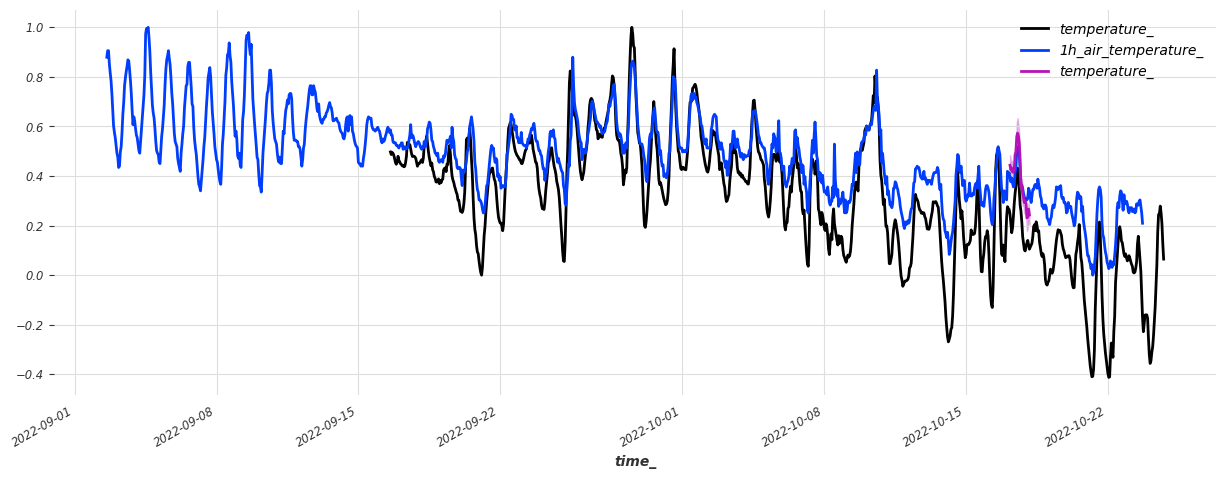

In [84]:
series_scaled['temperature_'].plot()
series_prediction_scaled['1h_air_temperature_'][:-25].plot()
prediction_tft['temperature_'].plot(low_quantile=0.05, high_quantile=0.95)

In [238]:
from darts.models import LightGBMModel
model_lgbm=LightGBMModel(
    output_chunk_length=N_FC,
    lags_future_covariates=[0, 24],
    lags_past_covariates=300,
    lags=300,
    queantiles=QUANTILES,
    likelihood='quantile',  
    model_name="LGBM_environment",
    log_tensorboard=True,
    add_encoders=add_encoders
)

In [ ]:
import numpy as np
import optuna
import torch
from optuna.integration import PyTorchLightningPruningCallback
from pytorch_lightning.callbacks import EarlyStopping

from darts.metrics import smape


# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 36)
    out_len = trial.suggest_int("out_len", 1, in_len-1)

    # Other hyperparameters
    kernel_size = trial.suggest_int("kernel_size", 2, 5)
    num_filters = trial.suggest_int("num_filters", 1, 5)
    weight_norm = trial.suggest_categorical("weight_norm", [False, True])
    dilation_base = trial.suggest_int("dilation_base", 2, 4)
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
    include_year = trial.suggest_categorical("year", [False, True])

    # throughout training we'll monitor the validation loss for both pruning and early stopping
    pruner = PyTorchLightningPruningCallback(trial, monitor="val_loss")
    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    callbacks = [pruner, early_stopper]

    # detect if a GPU is available
    if torch.cuda.is_available():
        pl_trainer_kwargs = {
            "accelerator": "gpu",
            "gpus": -1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
        }
        num_workers = 4
    else:
        pl_trainer_kwargs = {"callbacks": callbacks}
        num_workers = 0

    
    # reproducibility
    torch.manual_seed(42)

    # build the TCN model
    model = TCNModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=32,
        n_epochs=100,
        nr_epochs_val_period=1,
        kernel_size=kernel_size,
        num_filters=num_filters,
        weight_norm=weight_norm,
        dilation_base=dilation_base,
        dropout=dropout,
        optimizer_kwargs={"lr": lr},
        add_encoders=encoders,
        likelihood=GaussianLikelihood(),
        pl_trainer_kwargs=pl_trainer_kwargs,
        model_name="tcn_model",
        force_reset=True,
        save_checkpoints=True,
    )


    # when validating during training, we can use a slightly longer validation
    # set which also contains the first input_chunk_length time steps
    model_val_set = scaler.transform(series[-(VAL_LEN + in_len) :])

    # train the model
    model.fit(
        series=train,
        val_series=model_val_set,
        num_loader_workers=num_workers,
    )

    # reload best model over course of training
    model = TCNModel.load_from_checkpoint("tcn_model")

    # Evaluate how good it is on the validation set, using sMAPE
    preds = model.predict(series=train, n=val_len)
    smapes = smape(val, preds, n_jobs=-1, verbose=True)
    smape_val = np.mean(smapes)

    return smape_val if smape_val != np.nan else float("inf")


# for convenience, print some optimization trials information
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


# optimize hyperparameters by minimizing the sMAPE on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])
Hyperparameter opt